# PyQMagen

The Python version of QMagen provides a highly 
customizable package for the analysis of thermal data 
of quantum magnets. 
Featuring Bayesian optimizer for the fitting loss, 
and combined with an ED solver,
the PyQMagen is a computational light package 
that can analyze high temperature thermal data.

## Basic usage: data input, thermal data calculation, and inferring model parameters

---

We will demonstrate the basic workflow of PyQMagen package with a spin-chain model, with Hamiltonian 

$$
H = \sum_{\langle i,j \rangle} J_x S_i^x S_j^x + J_y S_i^y S_j^y 
+ J_z S_i^z S_j^z.
\tag{1}
$$




In [ ]:
import magen.solver as solver
from magen.models import chain
from magen.optimizer import BayesianOptimizer
from magen import visualize
import numpy as np
import matplotlib.pyplot as plt
from magen.aux_func import load_experiment_data

Experimental thermal data can be imported with function ```load_experiment_data```, with input ```experimental_files``` being a ```dict``` object defining name of thermal observables 
corresponding data files in .csv
format (with  ',' as delimiter).
The return is a ```ThObs``` object, with various thermal observables

>In */Data/demo_data*, you can find experimental data generated with theoretical calculation (at thermodynamic limit) by linearized tensor renormalization group (LTRG) method. The experimental data was generated with Hamiltonian in (1), and $J_x = J_y = 1, J_z = 1.5$.

In [2]:
experimental_files = {'T':'/Users/yusizhuo/GithubLocal/HamiltonianLearning/Data/demo_data/T.csv',
                     'C':'/Users/yusizhuo/GithubLocal/HamiltonianLearning/Data/demo_data/C.csv',
                     'Chiz':'/Users/yusizhuo/GithubLocal/HamiltonianLearning/Data/demo_data/Chiz.csv',
                     'Chixy':'/Users/yusizhuo/GithubLocal/HamiltonianLearning/Data/demo_data/Chixy.csv'}

# experimental_files = {'T':'/Users/yusizhuo/GithubLocal/HamiltonianLearning/Data/demo_data/T.csv',
#                      'C':'./Data/demo_data/C.csv',
#                      'Chiz':'./Data/demo_data/Chiz.csv',
#                      'Chixy':'./Data/demo_data/Chixy.csv'}


exp_thermal_data = load_experiment_data(experimental_files)

With ```model.chain```, we provided pre-defined templates for different spin models. 
Every model, for exemple, a ```chain``` object, has a method ```generate_interactions``` 
that can generate a interaction map with Hamiltonian parameters as its input.

In [3]:
mymodel = chain.XYZSpinChain(l=8)
interactions = mymodel.generate_interactions(Jx=3., Jy=3., Jz=3.)

Every element in ```interaction``` is a ```list``` or ```tuple``` object with following structure:

In [4]:
print(interactions[0])

['x', 'x', 0, 1, tensor(3.)]


for example, the above element defines interaction $3 \cdot S_0^x S_1^x$. 

You can also describe a customize Hamiltonian with this convention, by 
```interactions = custom_func(**parameter)```.

Then, after getting the interaction map, we can call a ```solver``` to calculate
thermal data:

In [5]:
# In EDSolver, by default chi_xy is not calculated
# by setting cal_chi_para=True we can compute chi in xy-plane

mysolver = solver.EDSolver(size=mymodel.l, cal_chi_para=True) 
thermal_data = mysolver.forward(interactions, 
                                T=exp_thermal_data.T, 
                                mag_field={'hx':0., 'hz':0.})

```forward``` function in ```solver``` with return a ```ThObs``` object. 

Let's see the difference between experimental specific heat and theoretical calculation:

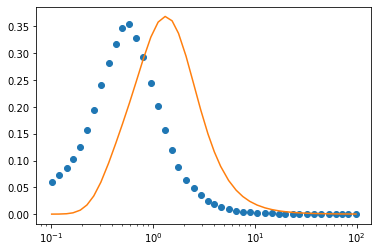

In [6]:
plt.semilogx(exp_thermal_data.T, exp_thermal_data.C, 'o')
plt.semilogx(exp_thermal_data.T, thermal_data.C.detach())

See the theorectical calculation does not match with the experimental data.
In this case, although we know the candidate material is a spin-chian material,
the parameter used for theoretical calculation $J_x=J_y=J_z=3$ differs from
the true paramter $J_x^*=J_y^*=1, J_z^*=1.5$. 

The search for true parameter can be automated with optimization over fitting loss 
$\mathcal{L}$. This scheme allow us to go beyond a handful of free parameters, reducing
human bias, and automate the entire process.

The recommended loss configuration is

$$
\mathcal{L}(\mathbf{x}) = \sum_{\alpha}\frac{1}{N_\alpha}
(\frac{O^\mathrm{exp}_\alpha-O^{\rm sim, \mathbf{x}}_\alpha}{O^{\rm exp}_\alpha})^2,
\tag{2}
$$

the sum of squared relative errors between $O^{\rm exp}_\alpha$ and $O^{\rm sim}_\alpha$,
the experimental and simulation data.

The loss function in (2) is the default loss function if not specificly defined differently.

In [7]:
Opt = BayesianOptimizer(parameter_space={'Jx':(-10, 10), 'Jy':(-10, 10), 'Jz':(-10, 10)},
                        n_exp_total=300,
                        solver=mysolver,
                        model=mymodel,
                        T_cut=0,
                        exp_thermal_data=exp_thermal_data,
                        record_BO = True,
                        target_obs=['C', 'Chiz', 'Chixy'])

```BayesianOptimizer``` is an efficient optimizer with relatively low dimensional parameter space, note  that the ```target_obs``` is a ```list``` of thermal observable names added into the loss computation.

The ```minimize``` function can be called to initiate the optimization process, and it will return a ```BayesianOptimizationResult``` object as its result.

In [8]:
res = Opt.minimize(log_accelerate=False)

|==================Optimization Start==================|
|   Itr    |   Loss   |    Jx    |    Jy    |    Jz    |
|    0     | 1.03e-01 | 8.83966  | 0.93952  | 8.82547  |
|    1     | 1.17e-01 | 9.99599  | 3.75402  | 7.28176  |
|    2     | 1.48e-01 | 4.24556  | -7.40987 | -0.90852 |
|    3     | 2.55e+00 | -0.52377 | -1.73526 | -9.71876 |
|    4     | 7.99e-02 | -2.08883 | -2.92812 | 6.29954  |
|    5     | 2.55e-01 | 9.50576  | -4.82579 | -4.38339 |
|    6     | 8.29e-01 | 7.39140  | -3.50708 | -8.79571 |
|    7     | 1.07e-01 | 4.90815  | 9.30516  | 3.80027  |
|    8     | 8.01e-02 | 0.78997  | 7.01077  | 3.28295  |
|    9     | 6.95e-02 | -3.97239 | 8.70306  | 5.66754  |
|    10    | 1.02e-01 | 6.75400  |-10.00000 | 5.05851  |
|    11    | 1.23e-01 | 0.62309  | 4.94839  | 10.00000 |
|    12    | 2.93e-02 | 5.43163  | -3.37281 | 4.43575  |
|    13    | 1.72e-01 |-10.00000 |-10.00000 | 10.00000 |
|    14    | 7.12e-01 |-10.00000 | 2.06928  | 10.00000 |
|    15    | 8.47e-02 | -1.0404

|   142    | 1.90e-03 | 1.43960  | 1.64067  | 0.67370  |
|   143    | 7.47e-04 | 1.45664  | 0.74820  | 1.17577  |
|   144    | 7.37e-04 | 1.16011  | -1.86037 | 2.60460  |
|   145    | 3.37e-04 | 0.87712  | 0.42928  | 1.77945  |
|   146    | 2.02e-04 | 0.83483  | 1.42661  | 1.31828  |
|   147    | 5.81e-04 | 0.65897  | 1.69522  | 1.26645  |
|   148    | 5.66e-01 | -9.57155 | 9.90730  | -9.76554 |
|   149    | 1.13e-03 | 1.29113  | 0.34645  | 1.31643  |
|   150    | 4.23e-03 | 0.48428  | -1.43532 | 2.47916  |
|   151    | 1.24e-01 | 9.93661  | 4.24677  | 9.88999  |
|   152    | 6.02e-02 | 4.72406  | 6.73996  | -2.37191 |
|   153    | 1.29e-01 | 3.73393  | 0.51974  | 9.71427  |
|   154    | 7.00e-02 | 8.65576  | -5.67853 | 6.34893  |
|   155    | 2.68e-04 | 0.87179  | 1.49254  | 1.23518  |
|   156    | 6.94e-04 | 0.99182  | 0.66375  | 1.37955  |
|   157    | 1.54e-04 | 0.91104  | 1.18859  | 1.52030  |
|   158    | 3.54e-04 | 1.08796  | 1.38486  | 1.11990  |
|   159    | 1.43e-04 | 0.88316

|   286    | 2.36e-04 | 0.88526  | 1.09733  | 1.63815  |
|   287    | 3.63e-04 | 0.90666  | 1.46262  | 1.10005  |
|   288    | 3.40e-04 | 1.36223  | 0.05574  | 1.87099  |
|   289    | 2.00e-03 | 1.69342  | -2.55074 | 2.88576  |
|   290    | 8.01e-02 | 7.52945  | -2.05354 | 5.32140  |
|   291    | 4.47e-04 | 1.05298  | 0.48394  | 1.90418  |
|   292    | 6.28e-02 | 0.54953  | 4.01954  | 5.72162  |
|   293    | 9.43e-02 | -1.83448 | 7.19333  | 1.44329  |
|   294    | 1.32e-01 | -7.03906 | -7.97340 | 9.94925  |
|   295    | 2.05e-04 | 0.82050  | 0.88303  | 1.59931  |
|   296    | 1.27e-04 | 0.89434  | 1.28929  | 1.32191  |
|   297    | 6.87e-04 | 1.08257  | -0.23346 | 1.86126  |
|   298    | 3.85e-04 | 0.98908  | 0.85744  | 1.76113  |
|   299    | 1.30e-01 | 9.73750  | 7.82462  | 7.59544  |
|=================Optimization Finised=================|
|   Best   |   Loss   |    Jx    |    Jy    |    Jz    |
|   274    | 6.42e-05 | 0.95051  | 0.99812  | 1.45092  |


note that we set ```log_accelerate=False```, using log scale during optimization can further improve efficiency. 
However, the log scale loss function will cause numercial problem for landscape prediction. If user wants to visualize the loss landscape, we recommand setting ```log_accelerate=False``` until the numerical issue being resolved in the future.

---

Visualizing the landscape is another benefit of the Bayesian optimizer. In short, a Gaussian process (GP) regression is used to fit the loss landscape, and predictions about mean and variance of loss at an unknown parameter point can be made by the GP.


/Users/yusizhuo/GithubLocal/HamiltonianLearning/magen/visualize/plot_funcs_2d.py:92: UserWarning: Using log scale might cause numerical errors when the parameter space is not fully explored (Gaussian process might predict negative values
  warnings.warn(warn_message)


(<Figure size 360x360 with 2 Axes>, <AxesSubplot:xlabel='Jx', ylabel='Jz'>)

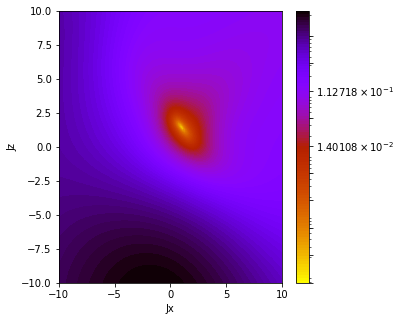

In [9]:
visualize.plot_funcs_2d.show_landscape(res,
                                       plan_keys=['Jx', 'Jz'],
#                                        fix_param={'Jy':1},
#                                        itr=-1, 
                                       log_scale=True,
                                      )

> ```itr``` default to be -1. Used to specify to check the landscape prediction at a given iteration

> ```plan_keys``` two parameter names of the 2d parameter plan to visualize the landscape

> ```fix_param``` if not specified, other parameters is set to their optimal values found during optimization. Can be specified using a dictionary